In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpplot as gpp
from poola import core as pool
import anchors
from adjustText import adjust_text

import core_functions as fns

gpp.set_aesthetics(palette='Set2')

In [4]:
def run_guide_residuals(lfc_df, paired_lfc_cols=[]):
    '''
    Calls get_guide_residuals function from anchors package to calculate guide-level residual z-scores
    Inputs:
    1. lfc_df: data frame with log-fold changes (relative to pDNA)
    2. paired_lfc_cols: grouped list of initial populations and corresponding resistant populations 
    
    '''
    lfc_df = lfc_df.drop_duplicates()
    if not paired_lfc_cols:
        paired_lfc_cols = fns.pair_cols(lfc_df)[1] #get lfc pairs 
    modified = []
    unperturbed = []
    #reference_df: column1 = modifier condition, column2 = unperturbed column
    ref_df = pd.DataFrame(columns=['modified', 'unperturbed'])
    row = 0 #row index for reference df 
    for pair in paired_lfc_cols:
        #number of resistant pops in pair = len(pair)-1
        res_idx = 1 
        #if multiple resistant populations, iterate 
        while res_idx < len(pair): 
            ref_df.loc[row, 'modified'] = pair[res_idx]
            ref_df.loc[row, 'unperturbed'] = pair[0]
            res_idx +=1 
            row +=1
    
    print(ref_df)
    #input lfc_df, reference_df 
    #guide-level
    residuals_lfcs, all_model_info, model_fit_plots = anchors.get_guide_residuals(lfc_df, ref_df)
    return residuals_lfcs, all_model_info, model_fit_plots

def select_top_ranks(df, rank = 5): #pick top ranks from each column of df with ranks, rank = top rank threshold (e.g. 5 if top 5)
    '''
    Inputs: 
    1. df: Dataframe with columns "Gene Symbol" and data used to rank 
    2. rank: top number of rows to select 
    Outputs:
    1. final_top_rank_df: Data frame with top ranked rows 
    '''
    rank_cols = df.columns.to_list()[1:]
    prev_top_rank_rows = pd.DataFrame(columns = df.columns)
    final_top_rank_df = pd.DataFrame() #for final list
    for col in rank_cols:
        #top_rank_rows = df.copy().loc[lambda df: df[col] <= rank, :] #pick rows with rank <= 5
        top_rank_rows = df.copy().nlargest(rank, col)
        top_rank_df = pd.concat([prev_top_rank_rows, top_rank_rows]) #concat with rows selected from previous column
        prev_top_rank_rows = top_rank_df #set combined list as previous

    final_top_rank_df = prev_top_rank_rows.drop_duplicates(subset = ['Gene Symbol']) #drop duplicate gene rows
    return final_top_rank_df


## Data summary
 

In [9]:
reads_1 = pd.read_csv('../../../Data/Reads/Goujon/Calu3/Brunello/counts-JD_GPP2726_Goujon_Plate3.txt', sep='\t')
reads_1 = reads_1[['Construct Barcode', 'Calu3-Brunello-MX1-initial population screen #2']].copy()

reads_2 = pd.read_csv('../../../Data/Reads/Goujon/Calu3/Brunello/counts-JD_GPP2727_GOUJON_20210707_Plate4.txt', sep='\t')
reads_2 = reads_2.copy().drop('Construct IDs', axis=1)

# get pDNA reads from Sanson et al., 2018
pDNA_reads_Sanson = pd.read_excel('../../../Data/Interim/Goujon/Calu3/Brunello/SansonetalSuppData1.xlsx', header=2)
pDNA_reads_Sanson = pDNA_reads_Sanson.copy().rename(columns={'sgRNA Sequence': 'Construct Barcode'})

reads_all = pd.merge(reads_1, reads_2, how = 'right', on ='Construct Barcode')

reads = pd.merge(pDNA_reads_Sanson[['Construct Barcode', 'pDNA']], reads_all, how = 'right', on ='Construct Barcode')
reads = reads.copy().drop(['EMPTY'], axis = 1)
reads

,Construct Barcode,pDNA,Calu3-Brunello-MX1-initial population screen #2,Calu3-Brunello-MX1-resistant population screen #2.1,Calu3-Brunello-MX1-resistant population screen #2.2,Calu3-Brunello-MX1-initial population screen #3,Calu3-Brunello-MX1-resitant population screen #3.1,Calu3-Brunello-MX1-resitant population screen #3.2
0,AAAAAAAATCCGGACAATGG,522,190,601,213,602,242,145
1,AAAAAAAGGATGGTGATCAA,511,561,973,952,880,467,290
2,AAAAAAATGACATTACTGCA,467,361,279,344,589,319,168
3,AAAAAAATGTCAGTCGAGTG,200,252,724,251,260,171,127
4,AAAAAACACAAGCAAGACCG,286,237,203,339,326,121,65
...,...,...,...,...,...,...,...,...
77436,TTTGTTTGGATTGCTTCAAG,514,210,245,311,463,245,162
77437,TTTTACCTTGTTCACATGGA,828,576,972,1622,1561,867,418
77438,TTTTGACTCTAATCACCGGT,588,759,1322,1009,897,656,339
77439,TTTTTAATACAAGGTAATCT,503,484,826,1073,812,396,158


In [10]:
# Gene Annotations
chip = pd.read_csv('../../../Data/Interim/Goujon/Calu3/Brunello/CP0041_GRCh38_NCBI_strict_gene_20210113.chip', sep='\t')
chip = chip.rename(columns={'Barcode Sequence':'Construct Barcode'})
chip_reads = pd.merge(chip[['Construct Barcode', 'Gene Symbol']], reads, on = ['Construct Barcode'], how = 'right')
chip_reads



,Construct Barcode,Gene Symbol,pDNA,Calu3-Brunello-MX1-initial population screen #2,Calu3-Brunello-MX1-resistant population screen #2.1,Calu3-Brunello-MX1-resistant population screen #2.2,Calu3-Brunello-MX1-initial population screen #3,Calu3-Brunello-MX1-resitant population screen #3.1,Calu3-Brunello-MX1-resitant population screen #3.2
0,AAAAAAAATCCGGACAATGG,SLC25A24,522,190,601,213,602,242,145
1,AAAAAAAGGATGGTGATCAA,FASTKD3,511,561,973,952,880,467,290
2,AAAAAAATGACATTACTGCA,BCAS2,467,361,279,344,589,319,168
3,AAAAAAATGTCAGTCGAGTG,GPR18,200,252,724,251,260,171,127
4,AAAAAACACAAGCAAGACCG,ZNF470,286,237,203,339,326,121,65
...,...,...,...,...,...,...,...,...,...
86978,TTTTGACTCTAATCACCGGT,INACTIVE_4T_54,588,759,1322,1009,897,656,339
86979,TTTTTAATACAAGGTAATCT,NO_SITE_940,503,484,826,1073,812,396,158
86980,TTTTTAATACAAGGTAATCT,INACTIVE_5T_55,503,484,826,1073,812,396,158
86981,TTTTTCTCACCCGATGAATC,NO_SITE_941,661,756,1269,918,931,468,291


In [11]:
#Calculate lognorm
cols = chip_reads.columns[2:].to_list() #reads columns = start at 3rd column
lognorms = fns.get_lognorm(chip_reads.dropna(), cols = cols)
lognorms

,Construct Barcode,Gene Symbol,pDNA_lognorm,Calu3-Brunello-MX1-initial population screen #2_lognorm,Calu3-Brunello-MX1-resistant population screen #2.1_lognorm,Calu3-Brunello-MX1-resistant population screen #2.2_lognorm,Calu3-Brunello-MX1-initial population screen #3_lognorm,Calu3-Brunello-MX1-resitant population screen #3.1_lognorm,Calu3-Brunello-MX1-resitant population screen #3.2_lognorm
0,AAAAAAAATCCGGACAATGG,SLC25A24,4.044396,2.959291,3.797441,2.636770,3.800197,3.216218,3.331339
1,AAAAAAAGGATGGTGATCAA,FASTKD3,4.015550,4.393088,4.452290,4.604541,4.314844,4.087832,4.257832
2,AAAAAAATGACATTACTGCA,BCAS2,3.894030,3.794633,2.805382,3.237168,3.770985,3.576801,3.523990
3,AAAAAAATGTCAGTCGAGTG,GPR18,2.794666,3.320339,4.048329,2.838050,2.719116,2.778264,3.160288
4,AAAAAACACAAGCAAGACCG,ZNF470,3.246765,3.240915,2.421864,3.218300,3.000423,2.363658,2.340226
...,...,...,...,...,...,...,...,...,...
86978,TTTTGACTCTAATCACCGGT,INACTIVE_4T_54,4.206314,4.811162,4.876997,4.685079,4.341074,4.553452,4.472123
86979,TTTTTAATACAAGGTAATCT,NO_SITE_940,3.994203,4.190976,4.227673,4.770454,4.204878,3.865042,3.443369
86980,TTTTTAATACAAGGTAATCT,INACTIVE_5T_55,3.994203,4.190976,4.227673,4.770454,4.204878,3.865042,3.443369
86981,TTTTTCTCACCCGATGAATC,NO_SITE_941,4.366491,4.805653,4.820016,4.554268,4.392145,4.090737,4.262539


## Quality Control
### Population Distributions

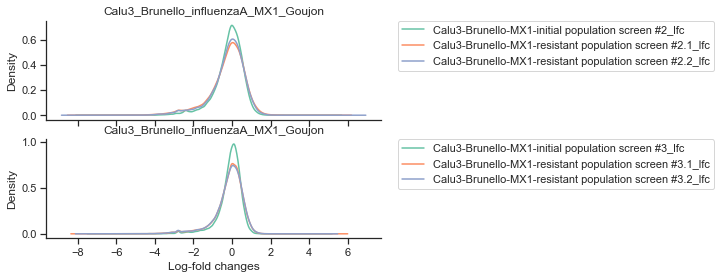

In [16]:
#Calculate log-fold change relative to pDNA
target_cols = list(lognorms.columns[3:])
pDNA_lfc = fns.calculate_lfc(lognorms,target_cols)
new_col_list = []
for col in pDNA_lfc.columns:
    if 'resitant'in col:
        new_col = col.replace('resitant', 'resistant')
        new_col_list.append(new_col)
    else:
        new_col_list.append(col)
pDNA_lfc.columns = new_col_list

pair_1 = [col for col in pDNA_lfc.columns if '#2' in col]
pair_2 = [col for col in pDNA_lfc.columns if '#3' in col]

paired_cols = (True, [pair_1, pair_2])

#Plot population distributions of log-fold changes 
fns.lfc_dist_plot(pDNA_lfc, paired_cols = paired_cols, filename = 'Calu3_Brunello_influenzaA_MX1_Goujon')


### ROC_AUC

Essential gene set: Hart et al., 2015 <br>
Non-essential gene set: Hart et al., 2014 <br>

Text(0, 0.5, 'True Positive Rate (essential)')

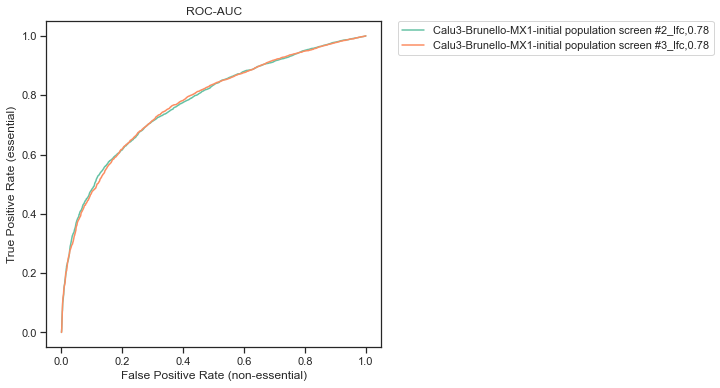

In [19]:
ess_genes, non_ess_genes = fns.get_gene_sets()
initial_cols = [col for col in pDNA_lfc.columns if 'initial' in col]

tp_genes = ess_genes.loc[:, 'Gene Symbol'].to_list()

fp_genes = non_ess_genes.loc[:, 'Gene Symbol'].to_list()

initial_roc_dict = {}
intial_roc_auc_dict = {}
for col in initial_cols:
    roc_auc, roc_df = pool.get_roc_aucs(pDNA_lfc, tp_genes, fp_genes, gene_col = 'Gene Symbol', score_col=col)
    initial_roc_dict[col] = roc_df
    intial_roc_auc_dict[col] = roc_auc

fig,ax=plt.subplots(figsize=(6,6))

for key, df in initial_roc_dict.items():
    roc_auc = intial_roc_auc_dict[key]
    ax=sns.lineplot(data=df, x='fpr',y='tpr', ci=None, label = key+',' + str(round(roc_auc,2)))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('ROC-AUC')
plt.xlabel('False Positive Rate (non-essential)')
plt.ylabel('True Positive Rate (essential)')


## Gene level analysis

### Residual z-scores

In [20]:
lfc_df = pDNA_lfc.drop('Gene Symbol', axis = 1)
lfc_df

,Construct Barcode,Calu3-Brunello-MX1-initial population screen #2_lfc,Calu3-Brunello-MX1-resistant population screen #2.1_lfc,Calu3-Brunello-MX1-resistant population screen #2.2_lfc,Calu3-Brunello-MX1-initial population screen #3_lfc,Calu3-Brunello-MX1-resistant population screen #3.1_lfc,Calu3-Brunello-MX1-resistant population screen #3.2_lfc
0,AAAAAAAATCCGGACAATGG,-1.085105,-0.246955,-1.407626,-0.244199,-0.828178,-0.713057
1,AAAAAAAGGATGGTGATCAA,0.377537,0.436740,0.588990,0.299294,0.072282,0.242282
2,AAAAAAATGACATTACTGCA,-0.099396,-1.088648,-0.656861,-0.123045,-0.317228,-0.370040
3,AAAAAAATGTCAGTCGAGTG,0.525673,1.253663,0.043384,-0.075550,-0.016402,0.365621
4,AAAAAACACAAGCAAGACCG,-0.005850,-0.824900,-0.028465,-0.246342,-0.883107,-0.906539
...,...,...,...,...,...,...,...
86978,TTTTGACTCTAATCACCGGT,0.604848,0.670683,0.478765,0.134760,0.347138,0.265808
86979,TTTTTAATACAAGGTAATCT,0.196773,0.233470,0.776251,0.210675,-0.129161,-0.550834
86980,TTTTTAATACAAGGTAATCT,0.196773,0.233470,0.776251,0.210675,-0.129161,-0.550834
86981,TTTTTCTCACCCGATGAATC,0.439161,0.453525,0.187776,0.025654,-0.275755,-0.103952


In [21]:
# run_guide_residuals(lfc_df.drop_duplicates(), cols)
residuals_lfcs, all_model_info, model_fit_plots = run_guide_residuals(lfc_df, paired_lfc_cols=paired_cols[1])
residuals_lfcs


                                            modified  \
0  Calu3-Brunello-MX1-resistant population screen...   
1  Calu3-Brunello-MX1-resistant population screen...   
2  Calu3-Brunello-MX1-resistant population screen...   
3  Calu3-Brunello-MX1-resistant population screen...   

                                         unperturbed  
0  Calu3-Brunello-MX1-initial population screen #...  
1  Calu3-Brunello-MX1-initial population screen #...  
2  Calu3-Brunello-MX1-initial population screen #...  
3  Calu3-Brunello-MX1-initial population screen #...  


,Construct Barcode,condition,residual,residual_z,unperturbed,lfc,lfc_reference
0,AAAAAAAATCCGGACAATGG,Calu3-Brunello-MX1-resistant population screen...,0.758826,1.234976,Calu3-Brunello-MX1-initial population screen #...,-0.246955,-1.085105
1,AAAAAAAATCCGGACAATGG,Calu3-Brunello-MX1-resistant population screen...,-0.447057,-0.787954,Calu3-Brunello-MX1-initial population screen #...,-1.407626,-1.085105
2,AAAAAAAGGATGGTGATCAA,Calu3-Brunello-MX1-resistant population screen...,0.233861,0.380604,Calu3-Brunello-MX1-initial population screen #...,0.436740,0.377537
3,AAAAAAAGGATGGTGATCAA,Calu3-Brunello-MX1-resistant population screen...,0.375396,0.661649,Calu3-Brunello-MX1-initial population screen #...,0.588990,0.377537
4,AAAAAAATGACATTACTGCA,Calu3-Brunello-MX1-resistant population screen...,-0.974270,-1.585609,Calu3-Brunello-MX1-initial population screen #...,-1.088648,-0.099396
...,...,...,...,...,...,...,...
309759,TTTTGACTCTAATCACCGGT,Calu3-Brunello-MX1-resistant population screen...,0.188465,0.414827,Calu3-Brunello-MX1-initial population screen #...,0.265808,0.134760
309760,TTTTTAATACAAGGTAATCT,Calu3-Brunello-MX1-resistant population screen...,-0.265625,-0.595929,Calu3-Brunello-MX1-initial population screen #...,-0.129161,0.210675
309761,TTTTTAATACAAGGTAATCT,Calu3-Brunello-MX1-resistant population screen...,-0.686692,-1.511462,Calu3-Brunello-MX1-initial population screen #...,-0.550834,0.210675
309762,TTTTTCTCACCCGATGAATC,Calu3-Brunello-MX1-resistant population screen...,-0.294488,-0.660682,Calu3-Brunello-MX1-initial population screen #...,-0.275755,0.025654


In [22]:
guide_mapping = pool.group_pseudogenes(chip[['Construct Barcode', 'Gene Symbol']], pseudogene_size=4, gene_col='Gene Symbol', control_regex=['ONE_INTERGENIC','NO_SITE'])
guide_mapping


,Construct Barcode,Gene Symbol
0,AAAAAAAATCCGGACAATGG,SLC25A24
1,AAAAAAAGGATGGTGATCAA,FASTKD3
2,AAAAAAATGACATTACTGCA,BCAS2
3,AAAAAAATGTCAGTCGAGTG,GPR18
4,AAAAAACACAAGCAAGACCG,ZNF470
...,...,...
86978,TTTTGACTCTAATCACCGGT,INACTIVE_4T_54
86979,TTTTTAATACAAGGTAATCT,NO_SITE_184
86980,TTTTTAATACAAGGTAATCT,INACTIVE_5T_55
86981,TTTTTCTCACCCGATGAATC,NO_SITE_115


In [23]:
gene_residuals = anchors.get_gene_residuals(residuals_lfcs.drop_duplicates(), guide_mapping)
gene_residuals

,condition,Gene Symbol,guides,avg_lfc,avg_lfc_reference,residual_zscore,p_value,fdr_bh
0,Calu3-Brunello-MX1-resistant population screen...,A1BG,4,0.258083,0.077318,0.821890,0.411140,0.936932
1,Calu3-Brunello-MX1-resistant population screen...,A1CF,4,0.070237,-0.059103,0.559908,0.575542,0.971026
2,Calu3-Brunello-MX1-resistant population screen...,A2M,4,-0.245830,-0.340072,0.096413,0.923192,0.993980
3,Calu3-Brunello-MX1-resistant population screen...,A2ML1,4,-0.368132,-0.480161,0.396114,0.692021,0.974980
4,Calu3-Brunello-MX1-resistant population screen...,A3GALT2,4,-0.018358,-0.266724,0.619027,0.535898,0.965015
...,...,...,...,...,...,...,...,...
83663,Calu3-Brunello-MX1-resistant population screen...,ZYG11A,4,0.127576,0.021322,0.687331,0.491874,0.962597
83664,Calu3-Brunello-MX1-resistant population screen...,ZYG11B,4,-0.134199,-0.114460,0.126817,0.899085,0.993686
83665,Calu3-Brunello-MX1-resistant population screen...,ZYX,4,-0.225586,0.070419,-1.126612,0.259906,0.933724
83666,Calu3-Brunello-MX1-resistant population screen...,ZZEF1,4,0.299107,0.158870,0.891584,0.372616,0.943785


In [24]:
gene_residual_sheet = fns.format_gene_residuals(gene_residuals, guide_min = 3, guide_max = 5)

guide_residual_sheet = pd.merge(guide_mapping, residuals_lfcs.drop_duplicates(), on = 'Construct Barcode', how = 'inner')
guide_residual_sheet

['Calu3-Brunello-MX1-resistant population screen #3.2_lfc', 'Calu3-Brunello-MX1-resistant population screen #2.2_lfc', 'Calu3-Brunello-MX1-resistant population screen #2.1_lfc', 'Calu3-Brunello-MX1-resistant population screen #3.1_lfc']
Calu3-Brunello-MX1-resistant population screen #3.2_lfc
Calu3-Brunello-MX1-resistant population screen #2.2_lfc
Calu3-Brunello-MX1-resistant population screen #2.1_lfc
Calu3-Brunello-MX1-resistant population screen #3.1_lfc


,Construct Barcode,Gene Symbol,condition,residual,residual_z,unperturbed,lfc,lfc_reference
0,AAAAAAAATCCGGACAATGG,SLC25A24,Calu3-Brunello-MX1-resistant population screen...,0.758826,1.234976,Calu3-Brunello-MX1-initial population screen #...,-0.246955,-1.085105
1,AAAAAAAATCCGGACAATGG,SLC25A24,Calu3-Brunello-MX1-resistant population screen...,-0.447057,-0.787954,Calu3-Brunello-MX1-initial population screen #...,-1.407626,-1.085105
2,AAAAAAAATCCGGACAATGG,SLC25A24,Calu3-Brunello-MX1-resistant population screen...,-0.636875,-1.428826,Calu3-Brunello-MX1-initial population screen #...,-0.828178,-0.244199
3,AAAAAAAATCCGGACAATGG,SLC25A24,Calu3-Brunello-MX1-resistant population screen...,-0.518380,-1.140994,Calu3-Brunello-MX1-initial population screen #...,-0.713057,-0.244199
4,AAAAAAAGGATGGTGATCAA,FASTKD3,Calu3-Brunello-MX1-resistant population screen...,0.233861,0.380604,Calu3-Brunello-MX1-initial population screen #...,0.436740,0.377537
...,...,...,...,...,...,...,...,...
347927,TTTTTCTCACCCGATGAATC,NO_SITE_115,Calu3-Brunello-MX1-resistant population screen...,-0.116948,-0.257412,Calu3-Brunello-MX1-initial population screen #...,-0.103952,0.025654
347928,TTTTTCTCACCCGATGAATC,INACTIVE_5T_56,Calu3-Brunello-MX1-resistant population screen...,0.213575,0.347590,Calu3-Brunello-MX1-initial population screen #...,0.453525,0.439161
347929,TTTTTCTCACCCGATGAATC,INACTIVE_5T_56,Calu3-Brunello-MX1-resistant population screen...,-0.065996,-0.116321,Calu3-Brunello-MX1-initial population screen #...,0.187776,0.439161
347930,TTTTTCTCACCCGATGAATC,INACTIVE_5T_56,Calu3-Brunello-MX1-resistant population screen...,-0.294488,-0.660682,Calu3-Brunello-MX1-initial population screen #...,-0.275755,0.025654


In [25]:
with pd.ExcelWriter('../../../Data/Processed/GEO_submission_v2/Calu3_Brunello_Goujon_influenzaA_MX1_v1.xlsx') as writer:  
    gene_residual_sheet.to_excel(writer, sheet_name='Calu3_avg_zscore', index =False)
    reads.to_excel(writer, sheet_name='Calu3_genomewide_reads', index =False)
    guide_mapping.to_excel(writer, sheet_name='Calu3_guide_mapping', index =False)

In [26]:
with pd.ExcelWriter('../../../Data/Processed/Individual_screens_v2/Calu3_Brunello_Goujon_influenzaA_MX1_v1.xlsx') as writer:  
    gene_residuals.to_excel(writer, sheet_name='condition_genomewide_zscore', index =False)
    guide_residual_sheet.to_excel(writer, sheet_name='guide-level_zscore', index =False)

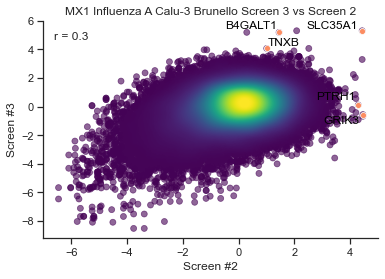

In [29]:
screen2_df = gene_residuals[gene_residuals['condition'].str.contains('#2')]
screen3_df = gene_residuals[gene_residuals['condition'].str.contains('#3')]

zscore_df = pd.merge(screen2_df[['Gene Symbol', 'residual_zscore']], screen3_df[['Gene Symbol', 'residual_zscore']], on = 'Gene Symbol', how = 'outer', suffixes = ['_screen#2', '_screen#3'])

zscore_annot_df = select_top_ranks(zscore_df)
fig, ax = plt.subplots()
ax = gpp.point_densityplot(zscore_df.dropna(), x='residual_zscore_screen#2', y='residual_zscore_screen#3')
ax = gpp.add_correlation(zscore_df.dropna(), x='residual_zscore_screen#2', y='residual_zscore_screen#3')
sns.scatterplot(data=zscore_annot_df.dropna(), x='residual_zscore_screen#2', y='residual_zscore_screen#3')
texts= []
for j, row in zscore_annot_df.dropna().iterrows():
    texts.append(ax.text(row['residual_zscore_screen#2'], row['residual_zscore_screen#3'], row['Gene Symbol'], 
                                  color = 'black'))
        # ensures text labels are non-overlapping
    adjust_text(texts)
sns.despine()
plt.title('MX1 Influenza A Calu-3 Brunello Screen 3 vs Screen 2')
plt.xlabel('Screen #2')
plt.ylabel('Screen #3')
fig.savefig('../../../Figures/InfluenzaAScreen3vs2.png', bbox_inches='tight')



In [30]:
with pd.ExcelWriter('../../../Data/Processed/Individual_screens_v2/Calu3_Brunello_Goujon_influenzaA_MX1_indiv_screen_v1.xlsx') as writer:  
    zscore_df.to_excel(writer, sheet_name='indiv_screen_genomewide_zscore', index =False)
    gene_residuals.to_excel(writer, sheet_name='condition_genomewide_zscore', index =False)
    guide_residual_sheet.to_excel(writer, sheet_name='guide-level_zscore', index =False)

## Comparison to influenza A screens 1 and 2

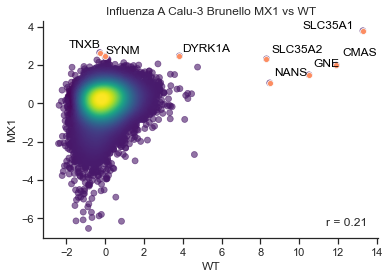

In [36]:
screens1and2 = pd.read_excel('../../../Data/Processed/GEO_submission_v2/Calu3_Brunello_Goujon_influenzaA_v1.xlsx')
influenzaA_comparison = pd.merge(screens1and2[['Gene Symbol', 'residual_zscore_avg']].copy(), gene_residual_sheet[['Gene Symbol', 'residual_zscore_avg']], on = 'Gene Symbol', how = 'outer', suffixes=['', '_MX1'])
influenzaA_comparison

influenzaA_annot_df = select_top_ranks(influenzaA_comparison)
fig, ax = plt.subplots()
ax = gpp.point_densityplot(influenzaA_comparison.dropna(), x='residual_zscore_avg', y='residual_zscore_avg_MX1')
ax = gpp.add_correlation(influenzaA_comparison.dropna(), x='residual_zscore_avg', y='residual_zscore_avg_MX1', loc = 'lower right')
sns.scatterplot(data=influenzaA_annot_df.dropna(), x='residual_zscore_avg', y='residual_zscore_avg_MX1')
texts= []
for j, row in influenzaA_annot_df.dropna().iterrows():
    texts.append(ax.text(row['residual_zscore_avg'], row['residual_zscore_avg_MX1'], row['Gene Symbol'], 
                                  color = 'black'))
        # ensures text labels are non-overlapping
    adjust_text(texts)
sns.despine()
plt.title('Influenza A Calu-3 Brunello MX1 vs WT')
plt.xlabel('WT')
plt.ylabel('MX1')
fig.savefig('../../../Figures/InfluenzaAComparison.png', bbox_inches='tight')
